# Available Bluebikes Predictor

My hobby project to predict the number of available bluebikes in 3 stations near my home using historical trip data and weather data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime
import os
from trip_data import get_data

## Extract and Combine Historical Bluebike Trip Data

Trip data consists of all Bluebike trips from Dec. 2023 to Jan. 2025.

In [2]:
# init data and download trip data csv files

data_path = './trip_data'

# trip data range, currently using 2023 Dec to 2025 Jan
start_year = 2024
end_year = 2025
start_month = 1
end_month = 1
start_date = datetime(start_year, start_month, 1)
end_date = datetime(end_year, end_month, 1)
current_date = start_date

# weather csv filename
weather_csv = f"{start_date.strftime('%Y%m%d')}-{datetime(end_date.year, end_month+1, 1).strftime('%Y%m%d')}-weather-data.csv"

In [108]:
get_data.get_weather_data(start_year, start_month, end_year, end_month+1, data_path)

Downloaded weather data: ./trip_data/20240101-20250201-weather-data.csv


In [6]:
get_data.get_bluebikes_trip_data(start_year,start_month,end_year,end_month,data_path)

https://s3.amazonaws.com/hubway-data/202312-bluebikes-tripdata.zip
Downloading: https://s3.amazonaws.com/hubway-data/202312-bluebikes-tripdata.zip
Downloaded: ./trip_data/202312-bluebikes-tripdata.zip
Extracted: 202312-bluebikes-tripdata.csv to ./trip_data
Deleted zip file: ./trip_data/202312-bluebikes-tripdata.zip
https://s3.amazonaws.com/hubway-data/202401-bluebikes-tripdata.zip
Downloading: https://s3.amazonaws.com/hubway-data/202401-bluebikes-tripdata.zip
Downloaded: ./trip_data/202401-bluebikes-tripdata.zip
Extracted: 202401-bluebikes-tripdata.csv to ./trip_data
Deleted zip file: ./trip_data/202401-bluebikes-tripdata.zip
https://s3.amazonaws.com/hubway-data/202402-bluebikes-tripdata.zip
Downloading: https://s3.amazonaws.com/hubway-data/202402-bluebikes-tripdata.zip
Downloaded: ./trip_data/202402-bluebikes-tripdata.zip
Extracted: 202402-bluebikes-tripdata.csv to ./trip_data
Deleted zip file: ./trip_data/202402-bluebikes-tripdata.zip
https://s3.amazonaws.com/hubway-data/202403-blueb

## Weather Data

In [3]:
weather_df = pd.read_csv(data_path + '/' + weather_csv, skiprows=2)

# rename columns
weather_df = weather_df.rename(columns={
    'temperature_2m (°C)': 'temperature',
    'precipitation (mm)': 'precipitation',
})


# convert time to datetime
weather_df['time'] = pd.to_datetime(weather_df['time'])

# interpolate weather data to 15 min intervals
weather_df_interpolated = weather_df.set_index('time').resample('15min').interpolate()

# reset index
weather_df_interpolated = weather_df_interpolated.reset_index()

# drop Feb 1 2025 data
weather_df_interpolated = weather_df_interpolated[weather_df_interpolated['time'].dt.date != datetime(2025, 2, 1).date()]


weather_df_interpolated

,time,temperature,precipitation
0,2024-01-01 00:00:00,-2.500,0.000
1,2024-01-01 00:15:00,-2.550,0.000
2,2024-01-01 00:30:00,-2.600,0.000
3,2024-01-01 00:45:00,-2.650,0.000
4,2024-01-01 01:00:00,-2.700,0.000
...,...,...,...
38107,2025-01-31 22:45:00,0.675,1.025
38108,2025-01-31 23:00:00,0.600,1.000
38109,2025-01-31 23:15:00,0.575,0.950
38110,2025-01-31 23:30:00,0.550,0.900


Quick Visualization of Weather

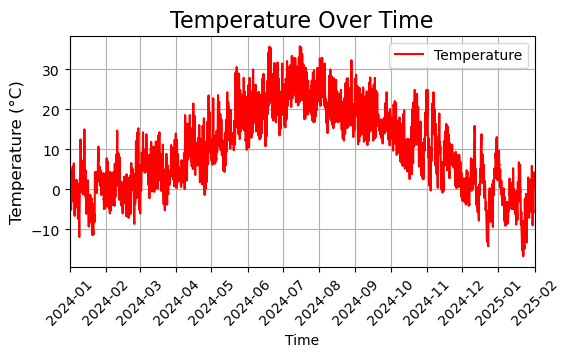

In [4]:
# Plot temperature over time
plt.figure(figsize=(6, 3))
sns.lineplot(x='time', y='temperature', data=weather_df_interpolated, color='red', label='Temperature')
plt.title('Temperature Over Time', fontsize=16)
plt.xlabel('Time', fontsize=10)
plt.ylabel('Temperature (°C)', fontsize=12)
plt.xticks(rotation=45)
plt.xlim(start_date, datetime(end_year, end_month+1,1))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.legend()
plt.grid(visible=True)
plt.show()

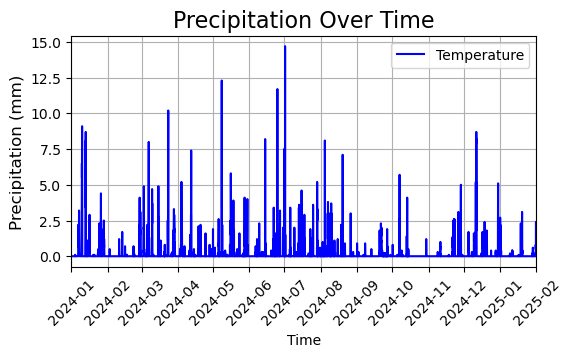

In [5]:
# Plot temperature over time
plt.figure(figsize=(6, 3))
sns.lineplot(x='time', y='precipitation', data=weather_df_interpolated, color='blue', label='Temperature')
plt.title('Precipitation Over Time', fontsize=16)
plt.xlabel('Time', fontsize=10)
plt.ylabel('Precipitation (mm)', fontsize=12)
plt.xticks(rotation=45)
plt.xlim(start_date, datetime(end_year, end_month+1,1))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.legend()
plt.grid(visible=True)
plt.show()

## Trip Data

Load and combine trip CSVs into one dataframe

In [6]:
# combine all trip data into one dataframe
data_frames = []

current_date = start_date

while current_date <= end_date:
    file = f"{current_date.strftime('%Y%m')}-bluebikes-tripdata.csv"
    file_path = os.path.join(data_path, file)
    df = pd.read_csv(file_path)
    data_frames.append(df)

    if current_date.month == 12:
            current_date = datetime(current_date.year + 1, 1, 1)
    else:
        current_date = datetime(current_date.year, current_date.month + 1, 1)

trip_data_df = pd.concat(data_frames, ignore_index=True)

Filter trips to only include stations near my home

In [7]:
# bluebike stations near me
# "A32012" : "Packard's Corner - Commonwealth Ave at Brighton Ave",
# "E32016" : "Commonwealth Ave at Naples Rd",
# "D32035" : "Harvard Ave at Brainerd Rd",
stations_of_interest = ["A32012", "E32016", "D32035"]
stations_docks = {
    "A32012" : 26,
    "E32016" : 19,
    "D32035" : 19
}

# filter trips that start or end at my stations
filtered_trip_data = trip_data_df[trip_data_df['start_station_id'].isin(stations_of_interest) | trip_data_df['end_station_id'].isin(stations_of_interest)].copy()

In [8]:
# remove milliseconds from start and end time
filtered_trip_data.loc[:, 'started_at'] = filtered_trip_data.started_at.str[:16]
filtered_trip_data.loc[:, 'ended_at'] = filtered_trip_data.ended_at.str[:16]

In [9]:
# convert start and end time to datetime
filtered_trip_data['started_at'] = pd.to_datetime(filtered_trip_data.loc[:,'started_at'])
filtered_trip_data['ended_at'] = pd.to_datetime(filtered_trip_data.loc[:,'ended_at'])

# sort by start time
filtered_trip_data.sort_values('started_at', inplace=True)

# remove rideable_type, member_casual columns
filtered_trip_data.drop('rideable_type', axis=1, inplace=True)
filtered_trip_data.drop('member_casual', axis=1, inplace=True)



filtered_trip_data.head()

,ride_id,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng
119455,04CDE2025D36951C,2024-01-01 00:50:00,2024-01-01 01:17:00,Union Square - Somerville,S32002,Harvard Ave at Brainerd Rd,D32035,42.379648,-71.095405,42.349530,-71.130228
96340,A2CACFC2A1914B69,2024-01-01 01:13:00,2024-01-01 01:29:00,Kenmore Square,B32010,Packard's Corner - Commonwealth Ave at Brighto...,A32012,42.348706,-71.097009,42.352261,-71.123831
83237,11CAC8544CB09F8E,2024-01-01 01:14:00,2024-01-01 01:21:00,Old Morse Park at Putnam Ave,M32076,Packard's Corner - Commonwealth Ave at Brighto...,A32012,42.357662,-71.108413,42.352261,-71.123831
47908,18429169FA12A03F,2024-01-01 01:16:00,2024-01-01 01:24:00,Commonwealth Ave at Naples Rd,E32016,MIT Vassar St,M32042,42.351911,-71.123798,42.355601,-71.103945
16161,BD88B024C011CEA5,2024-01-01 01:22:00,2024-01-01 01:25:00,Commonwealth Ave at Kelton St,D32034,Harvard Ave at Brainerd Rd,D32035,42.348359,-71.139972,42.349530,-71.130228


### Aggregate Trip Data

To guess the number of bikes available at a station, I will split the arrivals and departures for each station and round them into intervals.

### Trip Data Inspection

## Trip and Weather Relation

Below I will inspect relationship between number of trips and weather data.

## Prediction Model